# Recommendation Chatbot API: Evaluation

Usign **llama3-rec:latest** LLM.

In [1]:
%%capture output
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

BASE_PATH         = '../..'
API_PATH          = f'{BASE_PATH}/chat-bot-api'
LIB_PATH          = f'{BASE_PATH}/lib'
DATASET_PATH      = f'{BASE_PATH}/datasets'
METRICS_PATH      = f'{BASE_PATH}/metrics'
EVAL_METRICS_PATH = f'{METRICS_PATH}/evaluation-metrics.dt'
RUN_EVALUATION    = True

os.environ['TMP_PATH']         = f'{BASE_PATH}/tmp'
os.environ['DATASET_PATH']     = f'{BASE_PATH}/datasets'
os.environ['WEIGHTS_PATH']     = f'{BASE_PATH}/weights'
os.environ['METRICS_PATH']     = f'{BASE_PATH}/metrics'

sys.path.append(LIB_PATH)
sys.path.append(API_PATH)

In [3]:
import logging
import os
import pytorch_common.util as pu
import util as ut
from client import RecChatBotV1ApiClient
from models import EvaluationStateFactory, EvaluationState, ModelEvaluator

<Figure size 640x480 with 0 Axes>

## Setup

In [4]:
def on_file(file_path, format='%(asctime)s - %(levelname)s - %(message)s'):
    handler = logging.FileHandler(file_path)
    handler.setFormatter(logging.Formatter(format))
    return handler


pu.LoggerBuilder() \
    .handler(on_file('./evaluation.log'))\
    .on_console() \
    .build()

<RootLogger root (INFO)>

**Step 1**: Load interactions test set and items data.

In [5]:
interactions_test_set = ut.load_df(f'{DATASET_PATH}/interactions_test_set.json')
items                 = ut.load_df(f'{DATASET_PATH}/pre-processed-movies.json')

**Step 2**: Create evaluation state. 

* **EvaluationState** creates user profiles into **Chatbot API** from evaluation interactions.
* Register each user session data required to perform al evaluation metrics.
* Contains all data required to manage the evalauton process, like model hperparams, plot interval, etc..

In [6]:
if os.path.exists(EVAL_METRICS_PATH):
    logging.info('loading...')
    evaluation_state = EvaluationState.load(EVAL_METRICS_PATH)
    
    evaluation_state.max_patience= {
        20  : 5,
        100 : 6,
        200 : 7
    }
else:
    logging.info('creating...')
    evaluation_state = EvaluationStateFactory.create(
        api_client            = RecChatBotV1ApiClient(),
        interactions_test_set = interactions_test_set,
        items                 = items,
        recommendation_size   = 5,
        path                  = EVAL_METRICS_PATH,
        max_patience          = {
        20  : 5,
        100 : 6,
        200 : 7
        },
        plot_interval         = 5,
        hyper_params          = {
            'llm'                                   : 'llama3:instruct',
                                                    # llama3:instruct
                                                    # llama2:7b-chat
                                                    # mistral:instruct
            'retry'                                 : 1,
            'plain'                                 : False,
            'include_metadata'                      : True,
            'rag': {
                'shuffle'                           : False,
                'candidates_limit'                  : 100,
                'llm_response_limit'                : 100,
                'recommendations_limit'             : 10,
                'similar_items_augmentation_limit'  : 1,
                'not_seen'                          : True
            },
            'collaborative_filtering': {
                'shuffle'                           : False,
                'candidates_limit'                  : 50,
                'llm_response_limit'                : 50,
                'recommendations_limit'             : 10,
                'similar_items_augmentation_limit'  : 2,
                'text_query_limit'                  : 5000,
                'k_sim_users'                       : 10,
                'random_selection_items_by_user'    : 0.5,
                'max_items_by_user'                 : 10,
                'min_rating_by_user'                : 3.5,
                'not_seen'                          : True,
                'rank_criterion'                    : 'user_sim_weighted_pred_rating_score'
                                                    # user_sim_weighted_rating_score
                                                    # user_item_sim
                                                    # pred_user_rating
            }
        },
        verbose = True
    )

2024-06-19 10:15:44,028 - INFO - loading...


**Step 3**: Perform chatbot API evaluation process.
* Simulate user interaciton with API.
* A user requests movie recommendations that previously has rated.
* It process register recomemndations with result rating and user rating.
* It data is user to perform all metrics.

In [7]:
evaluator = ModelEvaluator(
    evaluation_state      = evaluation_state, 
    interactions_test_set = interactions_test_set,
    items                 = items,
    path                  = EVAL_METRICS_PATH,
    api_client            = RecChatBotV1ApiClient()
)

2024-06-19 10:15:45,351 - INFO - GET http://nonosoft.ddns.net:8080/api/v1/items?email=&seen=True&content=&all=True&limit=5&hide_emb=True&release=1950&genres=


2024-06-19 10:59:57,104 - INFO - Sessions: 133
2024-06-19 10:59:57,104 - INFO - Max Session Steps Reached: 19
2024-06-19 10:59:57,104 - INFO - Total Session Steps: 942
2024-06-19 10:59:57,111 - INFO - Mean NDCG: 0.97
2024-06-19 10:59:57,113 - INFO - Mean Average Precision: 0.46
2024-06-19 10:59:57,115 - INFO - Mean Reciprocal Rank: 0.81
2024-06-19 10:59:57,118 - INFO - Mean Recall: 0.56
2024-06-19 10:59:57,121 - INFO - Catalog Coverage: 0.12


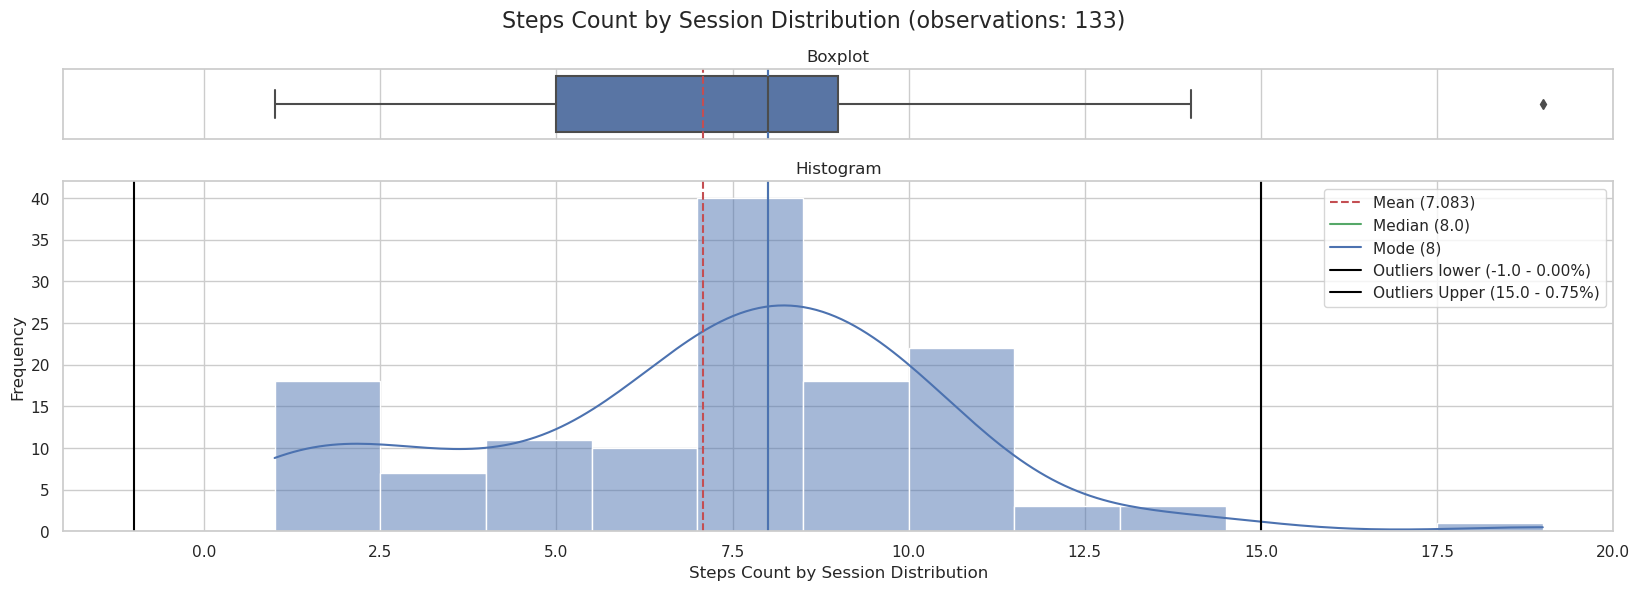

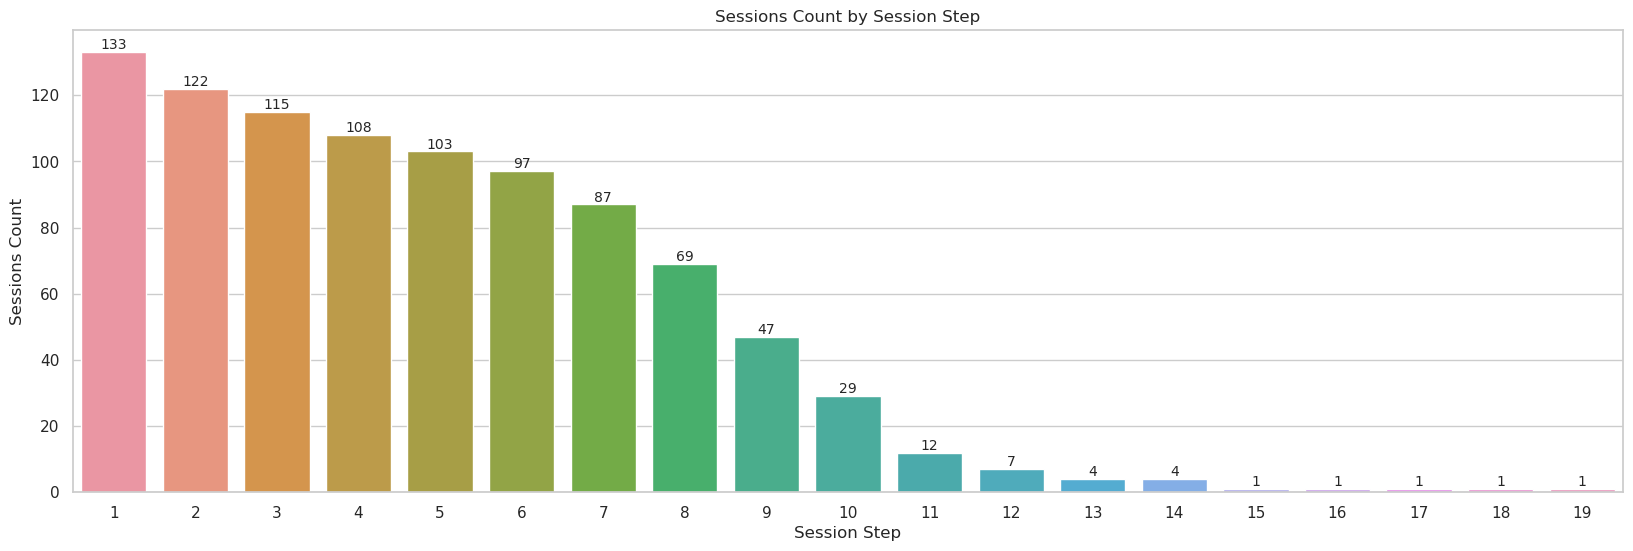

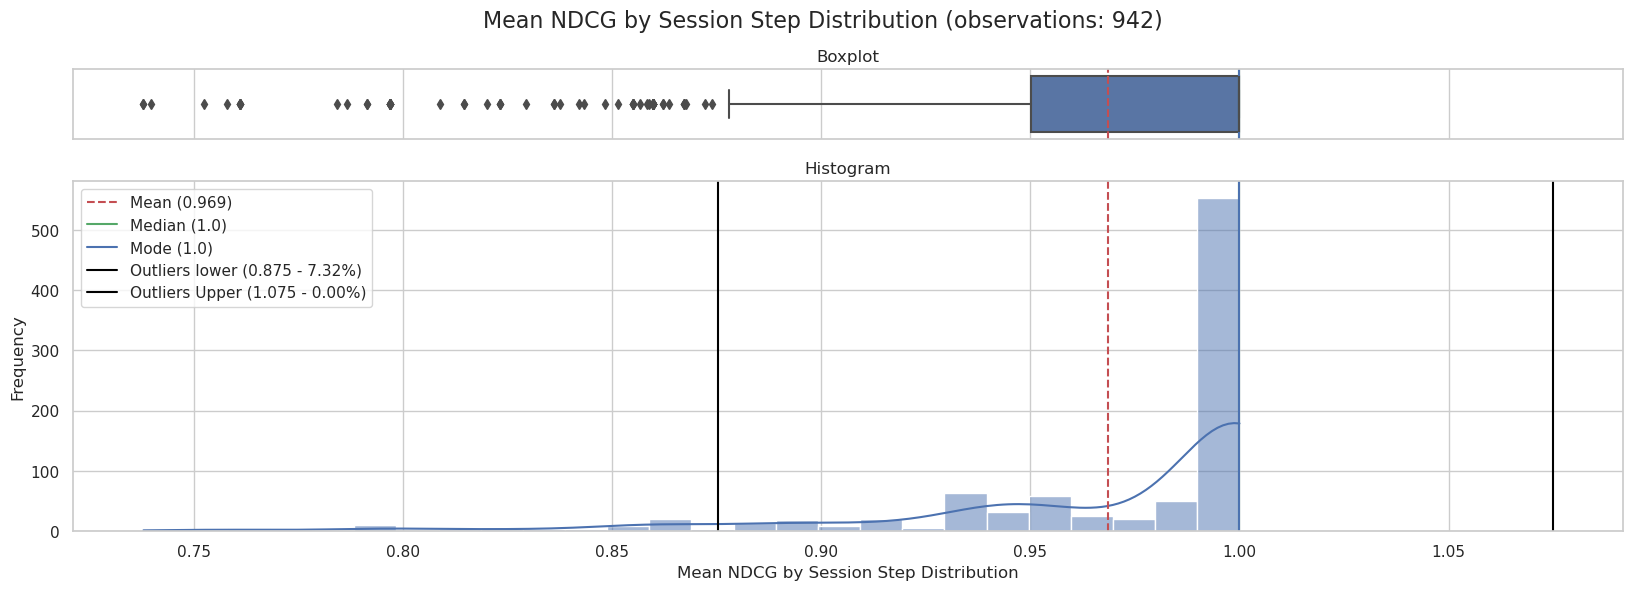

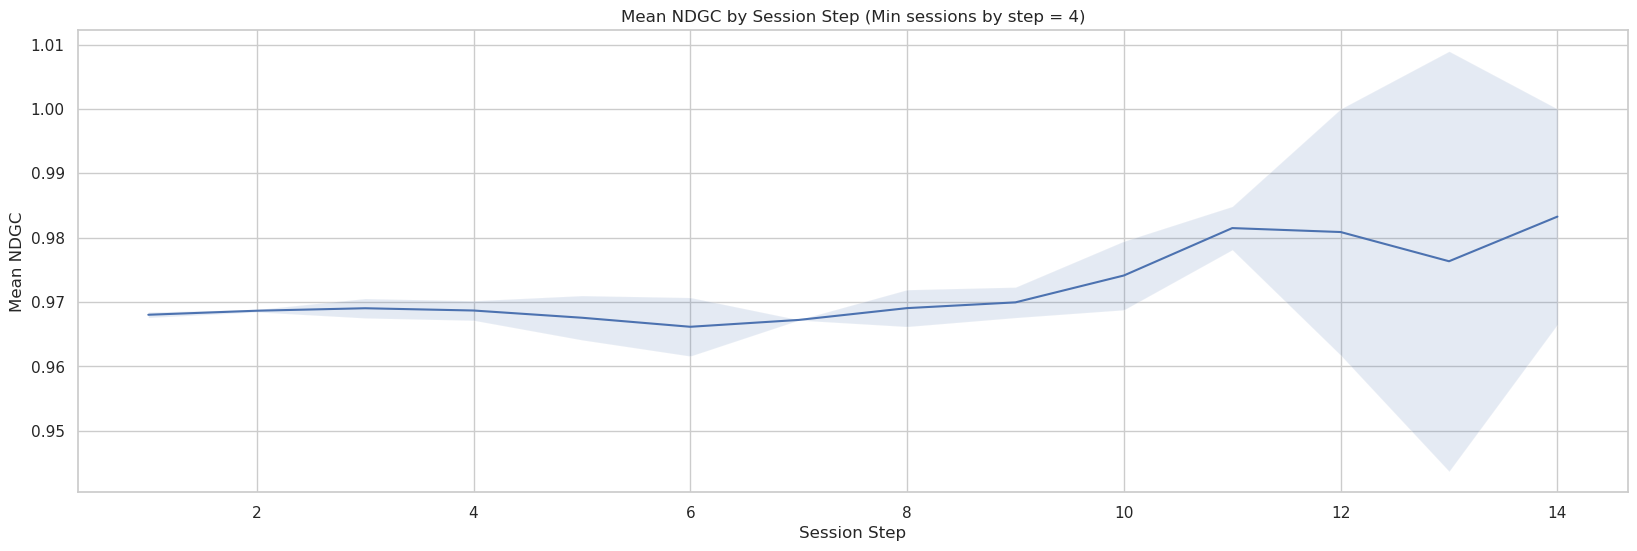

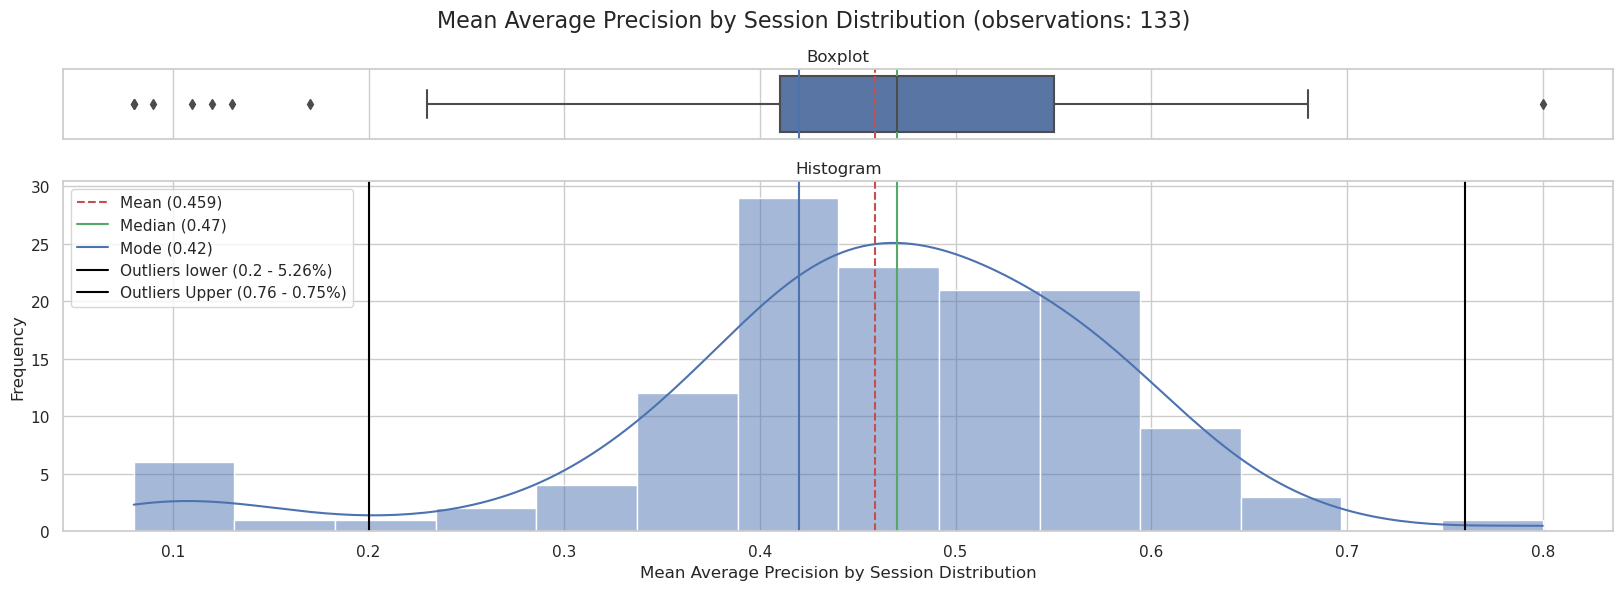

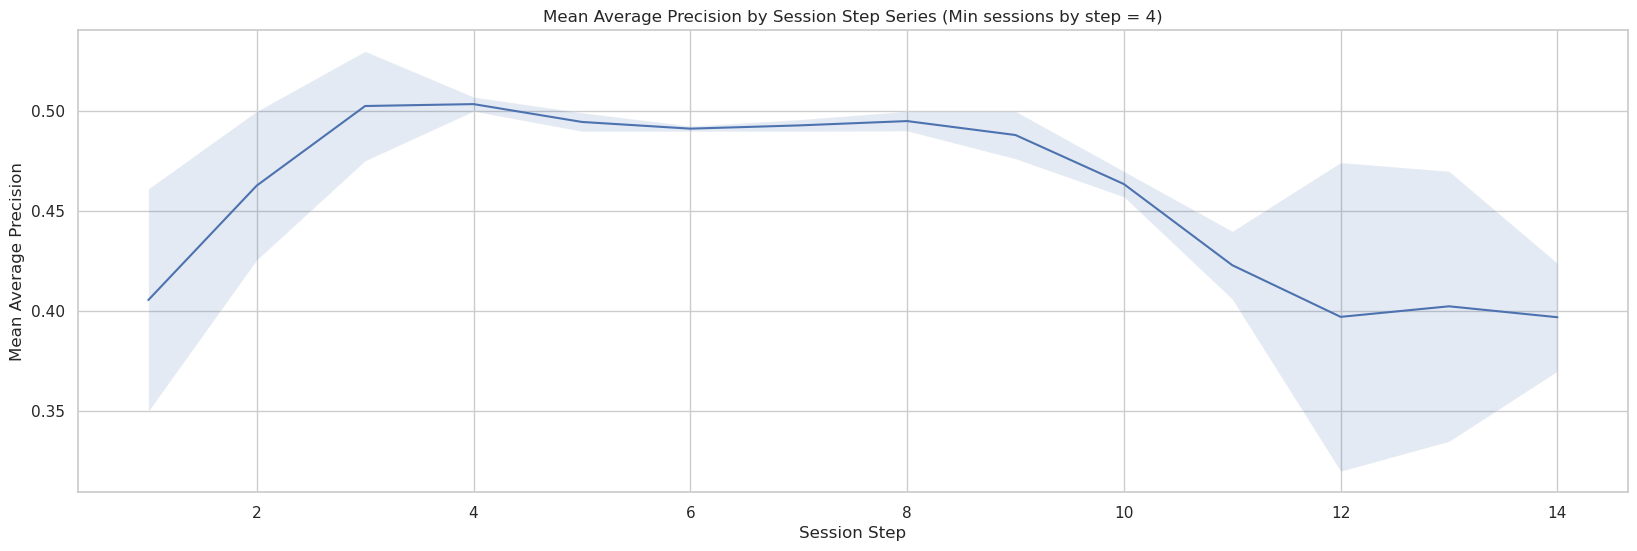

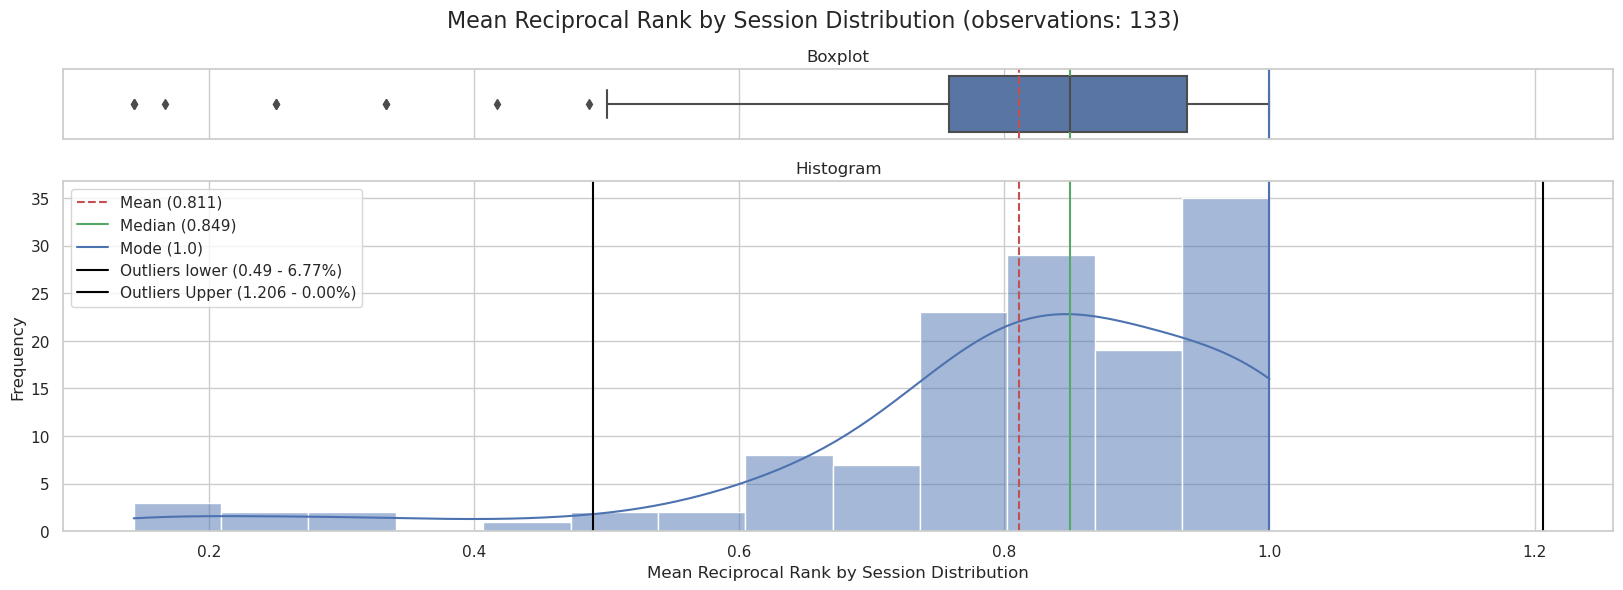

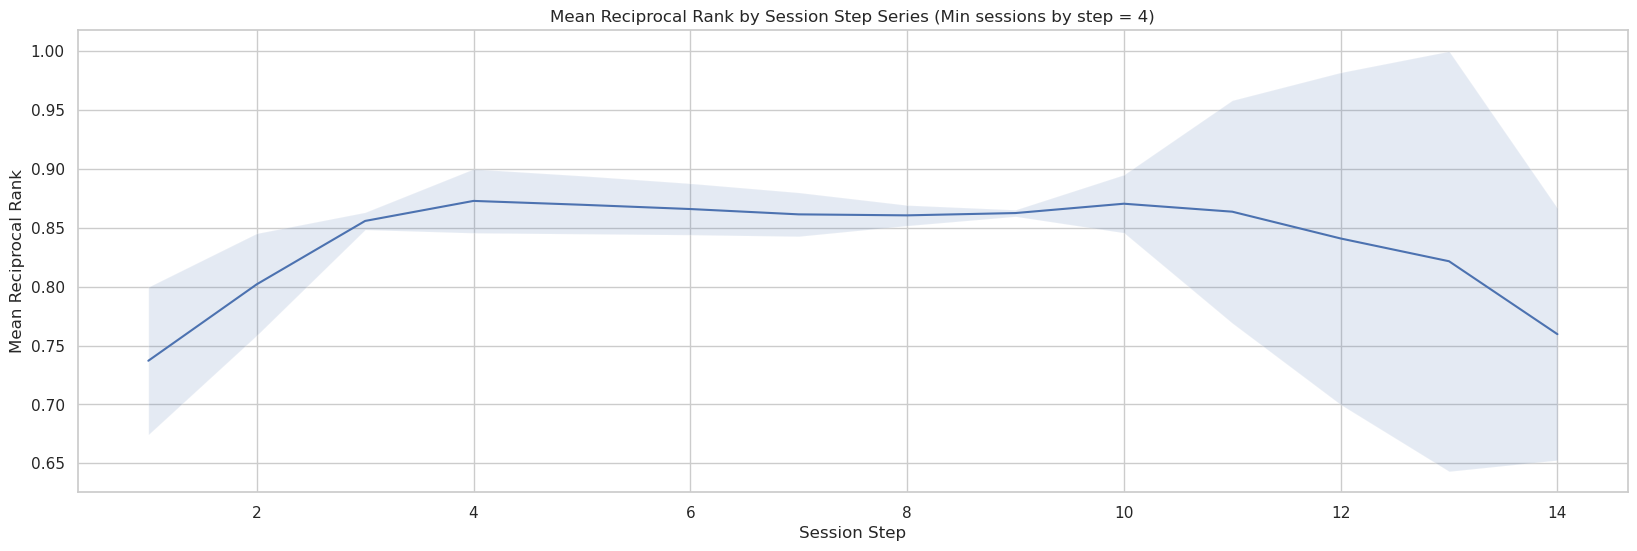

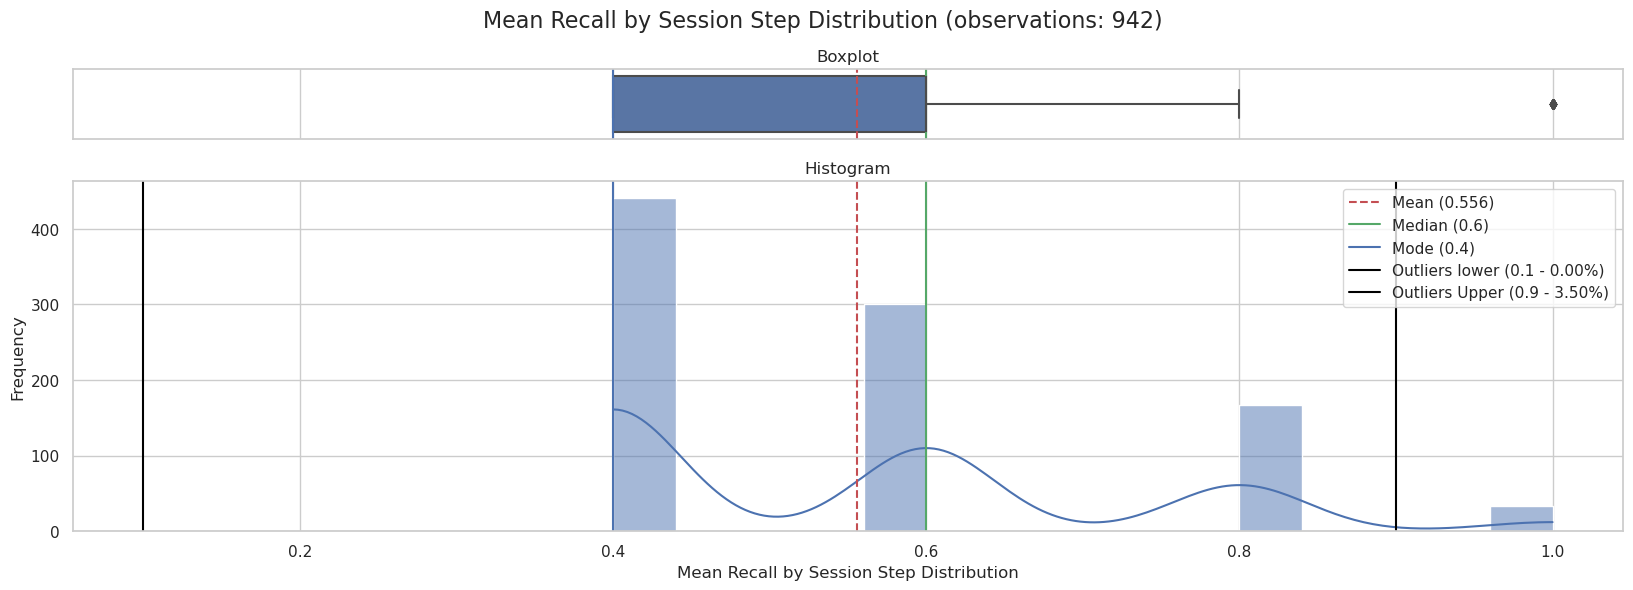

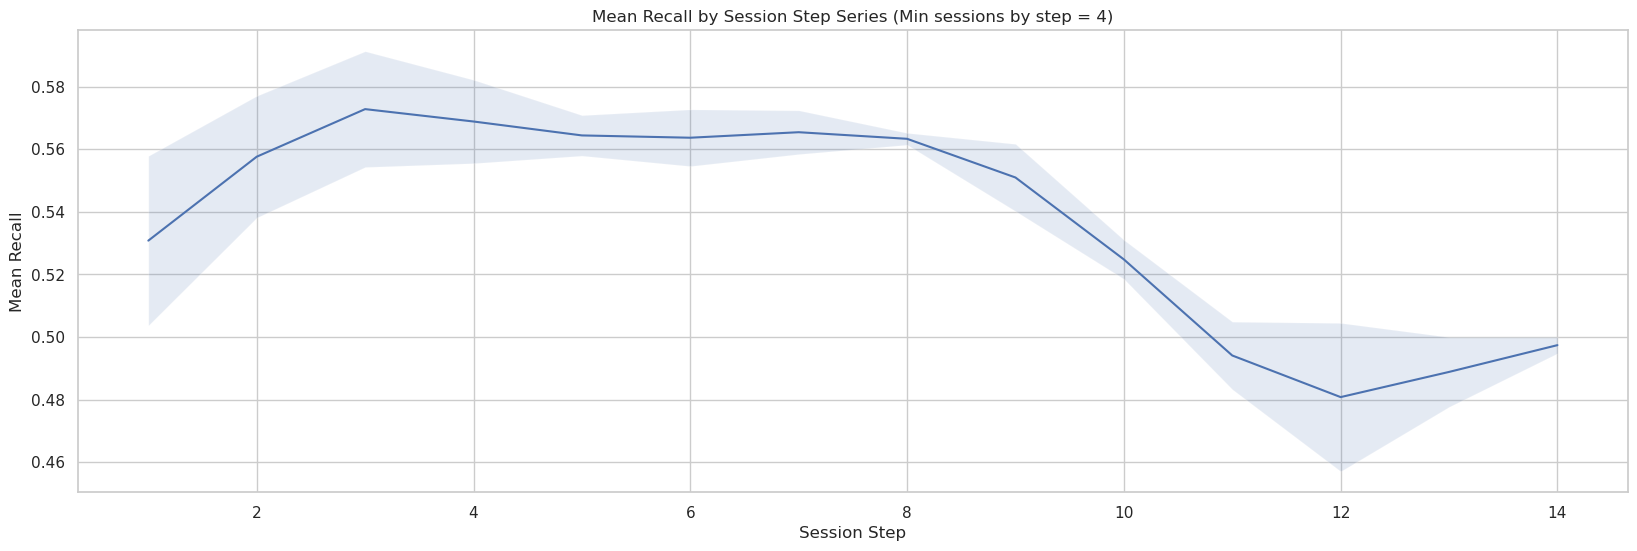

2024-06-19 10:59:58,943 - INFO - 16/135 - robert.bell@gmail.com - Begin user evaluation.
2024-06-19 10:59:58,984 - INFO - 16/135 - robert.bell@gmail.com - Sample: 5 - Remaining: 41/65.
2024-06-19 11:00:24,054 - INFO - 16/135 - robert.bell@gmail.com - Response time: 0:00:25.07
2024-06-19 11:00:24,054 - INFO - 16/135 - robert.bell@gmail.com - Not found relevant items into list of 10 recommendations - Patience: 1/6.
2024-06-19 11:00:24,082 - INFO - 16/135 - robert.bell@gmail.com - Sample: 5 - Remaining: 41/65.
2024-06-19 11:00:52,029 - INFO - 16/135 - robert.bell@gmail.com - Response time: 0:00:27.95
2024-06-19 11:00:52,029 - INFO - 16/135 - robert.bell@gmail.com - Not found relevant items into list of 10 recommendations - Patience: 2/6.
2024-06-19 11:00:52,057 - INFO - 16/135 - robert.bell@gmail.com - Sample: 5 - Remaining: 41/65.
2024-06-19 11:01:01,148 - INFO - 16/135 - robert.bell@gmail.com - Response time: 0:00:09.09
2024-06-19 11:01:01,148 - INFO - 16/135 - robert.bell@gmail.com - N

In [ ]:
if RUN_EVALUATION:
    evaluator.run()

In [ ]:
evaluator.plot()

Pendientes:
* Comparar el numero de sessiones por paso para cada modelo.